<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Guided Problem Set 14: Galaxy Rotation Curves</h1>


<a name='section_14_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P14.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_14_1">P14.1 Basic Setup</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_14_1">P14.1 Problems</a></td>
    </tr>   
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_14_2">P14.2 A More Realistic Simulation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_14_2">P14.2 Problems</a></td>
    </tr>  
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_14_3">P14.3 Simplified Matter Galaxy</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_14_3">P14.3 Problems</a></td>
    </tr>  
</table>

<h3>Learning Objectives</h3>

In this Pset, we will simulate a galaxy and use the output of this simulation to compute stellar rotation curves. Then, we will investigate how to model both visible matter and dark matter, again plotting rotation curves.

<h3>Importing Libraries</h3>

Before beginning, run the cells below to import the relevant libraries for this notebook.

In [16]:
#>>>RUN: P14.0-runcell00

#install the following if you have note done so:

#!pip install imageio
#!pip3 install torch torchvision torchaudio
#!pip install lmfit
#!pip install uproot

In [ ]:
#>>>RUN: P14.0-runcell01

import itertools
from IPython.display import HTML
from scipy.integrate import odeint
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import imageio
from IPython.display import Image
import random

import imageio
from PIL import Image
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import csv

<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.

In [17]:
#>>>RUN: P14.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title


<!--start-block-->
<a name='section_14_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P14.1 Basic Setup

| [Top](#section_14_0) | [Previous Section](#section_14_0) | [Problems](#problems_14_1) | [Next Section](#section_14_2) |

<h3>Overview</h3>

Let's start by seeing how a galaxy forms. To do that, randomly place a uniform distribution of stars and then evolve it under the forces of gravity. For the first part of this problem, we will use the parallelized part of the star evolution, as opposed to the tree structure.  

We'll begin by setting values for some parameters:

In [18]:
#>>>RUN: P14.1-runcell01

#Units
Gc=39.478 #AU^3/yr^2/Msun
re=1.0#AU
ve=2*np.pi*re#2pir/yr
Gmod=Gc/re**2

<h3> Basic Setup </h3>

Lets start by seeing how a galaxy forms. To do that, lets randomly place in a uniform distribution of stars, and then evolve it under forces of gravity. For the first part of this problem, we will use the parallelized part of the star evolution, as oppose to the tree structure.  

<a name='problems_14_1'></a>     

| [Top](#section_14_0) | [Restart Section](#section_14_1) | [Next Section](#section_14_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 14.1.1</span>


Edit the code below to complete `forcefunction_base` which takes arrays of stellar positions and masses and uses those to calculate an array of distances between stars $\Delta r^2_{ij}=\Delta x_{ij}^2 + \Delta y_{ij}^2 + \epsilon^2$ matrix. Be sure to add the softening term $\epsilon$. Use these distances to find the potential energy, as well as the gravitational forces and resulting accelerations. Hint: look to L19.2 for thoughts on what to do here.

After this problem, we'll use this function in the subsequent code to run the simulation and create the visualization.


In [26]:
#>>>PROBLEM: P14.1.1

#this function computes the force and potential energy of the system
def forcefunction_base(iR,iMass,iSoften):
    xpos=iR[:,0:1]
    ypos=iR[:,1:2]
    dx = xpos.T - xpos
    dy = ypos.T - ypos
    dr2  = dx**2 + dy**2 + iSoften**2
    dr1        = np.sqrt(dr2)
    dr2[dr2>0] = dr2[dr2>0]**(-1.5)
    ax   = Gmod * (dx*dr2) @ iMass
    ay   = Gmod * (dy*dr2) @ iMass
    a = np.hstack((ax,ay))
    pot = np.sum(-Gmod*np.outer(iMass.T, iMass)/dr1,axis=1) /iMass
    return a,pot





<h3>Define the Visualization</h3>

Having completed the code for `forcefunction_base`, run the cell below to define our visualization.

In [27]:
#>>>RUN

###Visualiztion code
def makePlot(nbody,coords,ax,fig,images,ymin=-2,ymax=2,xmin=-2,xmax=2):
    # plot and show learning process
    plt.cla()
    ax.set_xlabel('x(AU)', fontsize=24)
    ax.set_ylabel('y(AU)', fontsize=24)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    for body in range(nbody):
        ax.plot(np.flip(coords[body][:,0]),np.flip(coords[body][:,1]), 'o-',color = '#d2eeff',markevery=10000, markerfacecolor = '#0077BE',lw=2)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)


def animate(coords,iN=2,ymin=-10,ymax=10,xmin=-10,xmax=10,stepsize=50):
    images = []
    fig, ax = plt.subplots(figsize=(7,7))
    for step in range(len(coords[0])-110):
        if step % stepsize == 0:
            makePlot(iN,coords[:,step:step+100],ax,fig,images,ymin=ymin,ymax=ymax,xmin=xmin,xmax=xmax)
    return images


class AllStars:
    def __init__(self,iX,iV,iM,ibase=True,isoften=1e-2):
        self.rpos = iX
        self.v    = iV
        self.mass = iM
        self.n    = len(iX)
        self.posh   = np.array([])
        self.velh   = np.array([])
        self.enh    = np.array([])
        self.nsteps = 0
        self.soften = isoften
        self.base   = ibase

    def force(self): #take in arrays of everything
        if self.base:
            self.a,self.pot = forcefunction_base(self.rpos,self.mass,self.soften)
        else:
            self.a,self.pot = forcefunction(self.rpos,self.mass,self.soften)

    def firststep(self,dt):
        self.v    = self.v   +0.5*dt*self.a
        self.rpos = self.rpos+dt*self.v

    def step(self,dt):
        self.v    = self.v   +dt*self.a
        self.rpos = self.rpos+dt*self.v

    def store(self):
        lXs = self.rpos
        self.posh = np.append(self.posh,lXs)
        lVs = self.v
        self.velh = np.append(self.velh,lVs)
        lV2 = np.reshape((lVs[:,0]**2+lVs[:,1]**2),(self.n,1))
        lEn = 0.5*self.mass*lV2 + self.mass *self.pot
        self.enh  = np.append(self.enh,lEn)

    def points(self):
        return self.rpos

    def history(self):
        return np.reshape(self.posh,(self.nsteps,self.n,2))

    def velhistory(self):
        return np.reshape(self.velh,(self.nsteps,self.n,2))

    def enhistory(self):
        return np.reshape(self.enh,(self.nsteps,self.n))

    def allsteps(self,insteps=5000,dt=0.001):
        nsteps=insteps
        self.nsteps+=nsteps
        self.force()
        self.firststep(dt)
        for t in range(nsteps):
            self.force()
            self.step(dt)
            self.store()
        return self.points()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 14.1.2</span>


Now, let's check if the output of this code makes sense by running an example where we know the answer. Perform a 2-body simulation for a circular orbit of a binary star system with each of the stars having exactly one solar mass and a radius of 1 AU (i.e. the two stars are 2 AU apart). Recall that

$$\frac{\mu v^2}{r } = \frac{GM_{1}M_{2}}{r^2}$$

Run the simulation for increasing values of the timestep `dt` and observe what happens. At what value of `dt` does the simulation break down, in that the orbits no longer remain relatively stable? Enter a number with precision 0.05.


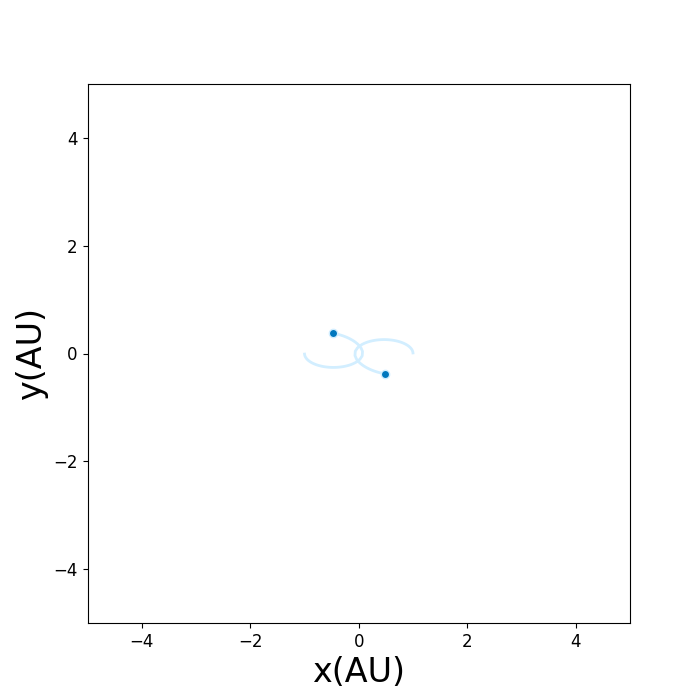

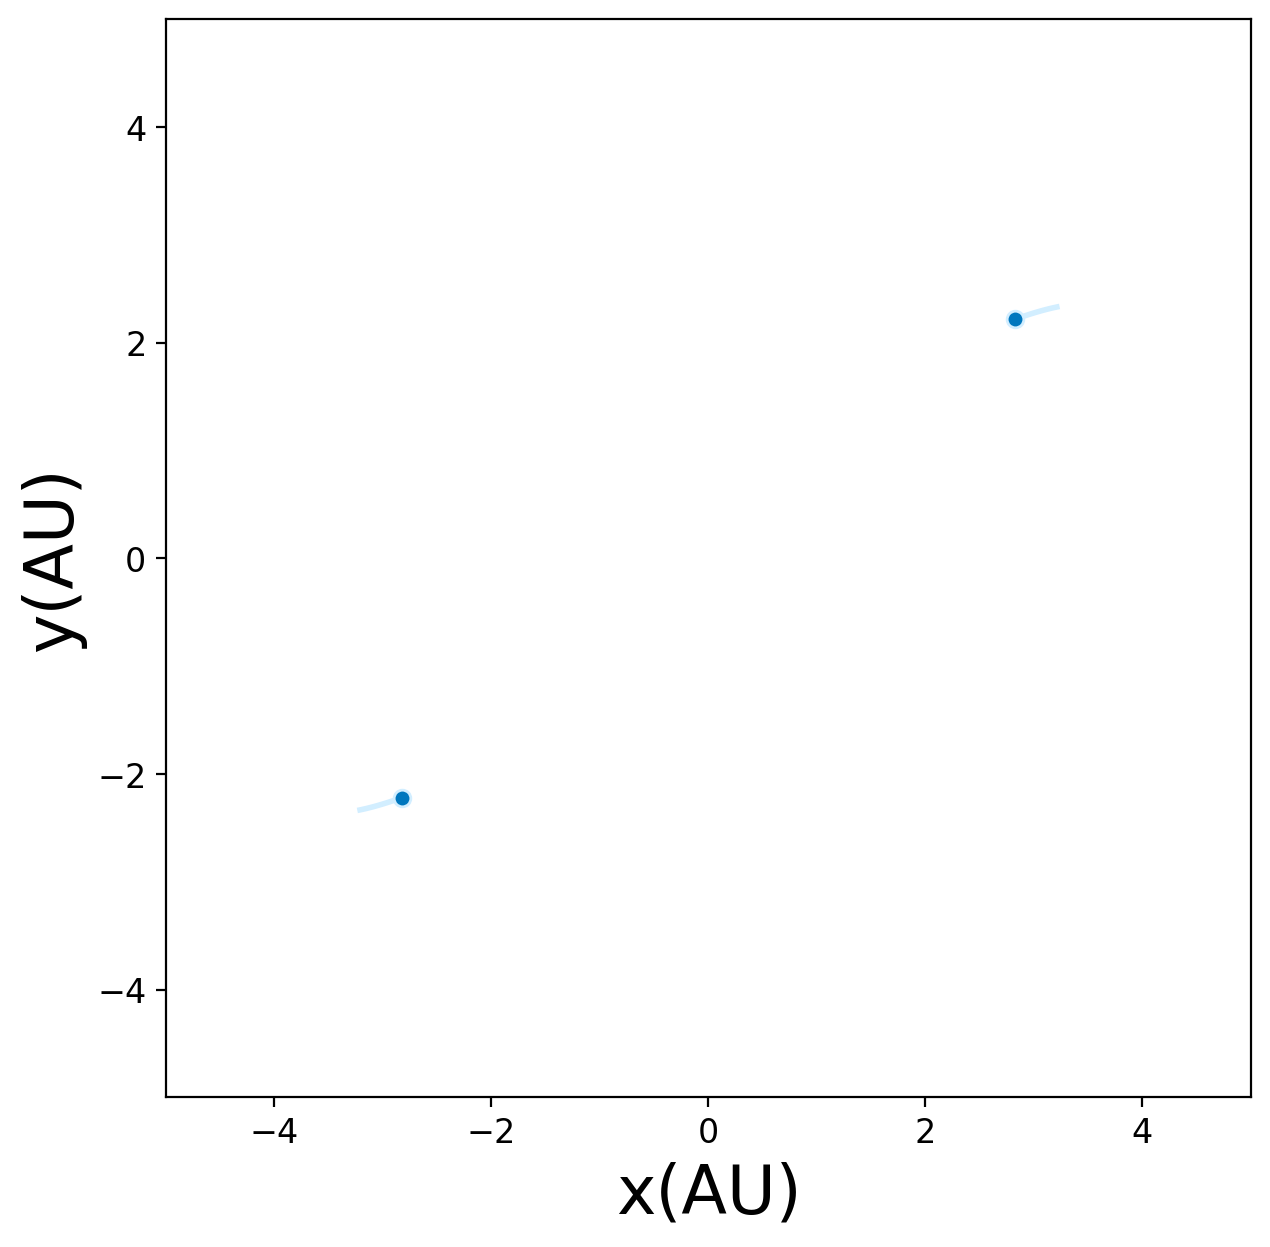

In [43]:
#>>>PROBLEM: P14.1.2

np.random.seed(1234)
nStar=2
X = np.zeros((nStar, 2))
V = np.zeros((nStar, 2))
M = np.ones((nStar,1))

vcircle = np.sqrt(Gc*1.0/(4*2.0))

X[0,0] =  1
X[1,0] = -1
V[0,1] =  vcircle*0.5
V[1,1] = -vcircle*0.5

allStar = AllStars(X,V,M)
Xout=allStar.allsteps(insteps=5000,dt=4.9e-3) ###for what dt does this stops working?

tracks=allStar.history()
tracks=np.swapaxes(tracks,0,1)
images=animate(tracks,iN=nStar,xmin=-5,xmax=5,ymin=-5,ymax=5,stepsize=100)
imageio.mimsave('./orbit_n_v2_v1.gif', images, fps=10, loop=0)
Image(open('orbit_n_v2_v1.gif','rb').read())


<!--start-block-->
<a name='section_14_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P14.2 A More Realistic Simulation

| [Top](#section_14_0) | [Previous Section](#section_14_1) | [Problems](#problems_14_2) | [Next Section](#section_14_3) |

<a name='problems_14_2'></a>     

| [Top](#section_14_0) | [Restart Section](#section_14_2) | [Next Section](#section_14_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 14.2.1</span>

Now, we'll make a realistic galaxy simulation so that we can study how galaxies form and ultimately make some rotation curves. Let's start by randomly placing the stars with a uniform density in a rectangular grid of size 20000$\times$20000 AU. To start, we sample 50 stars and evolve it. The typical density of stars at the center of a galaxy is about 1 star per square of 500$\times$500 AU, which equates to about 20 times the density we consider here.  As usual, give the stars 1 solar mass. In this example, the stars start with zero velocity.

Run this simulation in two modes, First, to make sure the motion makes sense start with 1000 steps or so (parameter `insteps` in the code). Choose an appropriate time step and softening parameter. Then, when you are convinced the code is working reasonably, run it for a much long period (1 Million years or so). This long simulation will allow us to study how the galaxy evolves.


Thinking about ways to check the accuracy of this simulation, what should happen to the center of mass and angular momentum of the system? Select ALL that apply.

A) Center of mass stays in the same location\
B) Center of mass moves\
C) Angular momentum stays the same\
D) Angular momentum changes


In [ ]:
#>>>PROBLEM: P14.2.1

#First we will sample 3000 stars in 2D space with 2D velocity
nStar=50
np.random.seed(1234)

X = #YOUR CODE HERE

V = np.zeros((nStar, 2))
M = np.ones((nStar,1))

#ADJUST THE SIMULATION BELOW
allStar = AllStars(X,V,M,isoften=1e3)
Xout=allStar.allsteps(insteps=40000,dt=25.)
tracks=allStar.history()
tracks=np.swapaxes(tracks,0,1)
images=animate(tracks,iN=nStar,xmin=-4e4,xmax=4e4,ymin=-4e4,ymax=4e4,stepsize=100)
imageio.mimsave('./orbit_n.gif', images, fps=10)
Image(open('orbit_n.gif','rb').read())


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 14.2.2</span>

Now, let's look at some common sense quantitative checks of our simulation. We want to know:

A) What is the maximum movement of the center of mass of the total system?  

B) What is the change in velocity of the center of mass of the system?

C) What is the change in the angular of momentum of the total system from beginning to end?

D) What is the change in its energy?

Edit the code to calculate the position of the center of mass, the distance of each star from the center of mass, and the total angular momentum.

The remainder of the code is set up to calculate the observables listed above. Determine the order-of-magnitude answers to the four questions (for instance, `2.567e-10` would be expressed as `1e-10`, `7.567e-10` would be expressed as `1e-9`, and `2.567` would be expressed as `1e1`, etc.). Report your results as a list of numbers.


In [ ]:
#>>>PROBLEM: P14.2.2

def centerOfMass(iVec):
    center = #YOUR CODE HERE: compute center of mass
    return center

def angMomentun(iR,iV):
    center = centerOfMass(iR)
    shift = #YOUR CODE HERE: Shift coordinates by center
    ang = #YOUR CODE HERE: angular mometnum
    return np.sum(ang,axis=0)

tracks=allStar.history()
comX0=centerOfMass(tracks[0])
comX1=centerOfMass(tracks[-1])
print("com0",comX0,"com1",comX1)
print("delta_com", np.sqrt(np.sum((comX1 - comX0)**2.)))
print()

veltracks=allStar.velhistory()
vcomX0=centerOfMass(veltracks[0])
vcomX1=centerOfMass(veltracks[-1])
print("vel com0",vcomX0,"vel com1",vcomX1)
print("delta_com_vel", np.sqrt(np.sum((vcomX1 - vcomX0)**2.)))
print()

LcomX0=angMomentun(tracks[0],veltracks[0])
LcomX1=angMomentun(tracks[-1],veltracks[-1])
print("L com0",LcomX0,"L com1",LcomX1)
print("delta_com_L", abs(LcomX1 - LcomX0))
print()

enhist=allStar.enhistory()
enhisttot=np.sum(enhist,axis=1)
E0 = enhisttot[0]
E1 = enhisttot[-1]
print("E tot",E0,"E final",E1)
print("delta_E", abs(E1 - E0))


The following code shows the time evolution of the total angular momentum and energy.

In [ ]:
#>>>RUN

##Now some fun plots
def centerOfMassTime(iVec):
    center=np.sum(iVec,axis=1)/iVec.shape[1]
    return center

def shiftCOM(iR):
    center=centerOfMassTime(iR)
    shift=iR
    for pVal in range(iR.shape[1]):
        shift[:,pVal] -= center
    return shift

def angMomentumTime(iR,iV):
    shift=shiftCOM(iR)
    ang=shift[:,:,0]*iV[:,:,1]-shift[:,:,1]*iV[:,:,0]
    return np.sum(ang,axis=1)


Ltime=angMomentumTime(tracks,veltracks)
plt.plot(Ltime)
plt.xlabel("iter")
plt.ylabel("L")
plt.show()

plt.plot(enhisttot)
plt.xlabel("iter")
plt.ylabel("E")
plt.show()


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 14.2.3</span>

Now that we have made some basic checks, let's start looking at properties of the evolution. Write a script to study the average density before and after the simulation. More specifically, roughly what fraction of the stars are more than 10,000 AU away from the center of mass at the beginning and roughly what fraction are more than 10,000 AU away from the center of mass after at least 1 Million years of evolution. Report your answer as a list of two numbers, `[frac_before, frac_after]`, with precision `6e-2`.


In [ ]:
#>>>PROBLEM: P14.2.3

def makeRadiusHist(iX):
    shift=shiftCOM(iX)
    evts,bin_edges=np.histogram(np.sqrt(shift[:,0]**2+shift[:,1]**2),bins=10,range=[0,2e4],density=True)
    bin_centers=0.5*(bin_edges[1:]+bin_edges[:-1])
    return bin_centers,evts

def plotRadius(iTracks):
    pX0,pY0 = makeRadiusHist(iTracks[0])
    plt.plot(pX0,pY0,drawstyle = 'steps-mid',label='start',c='blue')
    pX1,pY1 = makeRadiusHist(iTracks[-1])
    plt.plot(pX1,pY1,drawstyle = 'steps-mid',label='end',c='red')
    plt.legend()
    plt.xlabel("r(AU)")
    plt.ylabel("N")
    plt.show()

plotRadius(tracks)

#now density => each bin divide by r => rho=N/2pirdr
pX0,pY0 = makeRadiusHist(tracks[0])
pX1,pY1 = makeRadiusHist(tracks[-1])
plt.plot(pX0,pY0/pX0,drawstyle = 'steps-mid',label='start',c='blue')
plt.plot(pX1,pY1/pX1,drawstyle = 'steps-mid',label='end',c='red')
plt.legend()
plt.xlabel("r(AU)")
plt.ylabel("rho")
plt.show()

def fraction(iX,iR=10000):
    ## YOUR CODE HERE
    return frac

frc0=fraction(tracks[0])
frc1=fraction(tracks[-1])
print("Fraction:",frc0," Updated Fraction",frc1)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 14.2.4</span>

Now, continue your quantitative study of how the galaxy evolves. Plot the average final radial velocity versus radius of the toy galaxy and use that plot to estimate by eye the average radial velocity of the inner 80% of the stars (i.e. those with up to 80% of the maximum radius) compared to the outer 20%? Report your answer as a list of two numbers, `[vel_inner, vel_outer]` with units of AU/year and precision `0.05`.


In [ ]:
#>>>PROBLEM: P14.2.4

def plotRvsV(iR,iV,iNbins=5):
    #Sort data array in R
    sort = #get sorted indices
    #split data into nbins
    corrXsort = iR[sort]
    corrYsort = iV[sort]
    ncands=len(iV)//iNbins
    corrXsort = np.reshape(corrXsort,(ncands,iNbins))
    corrXmean = #compute Xsort mean in bins
    corrXrms  = #compute Xsort std in bins

    corrYsort = np.reshape(corrYsort,(ncands,iNbins))
    corrYmean = #compute Ysort mean in bins
    corrYrms  = #compute Ysort std in bins
    return corrXmean,corrYmean,corrXrms,corrYrms

##Now some fun plots
def shiftCOM(iR):
    center=#compute center of mass
    shift=iR
    #shift it
    for pVal in range(iR.shape[0]):
        shift[pVal] -= center
    return shift

def velCOM(iX,iV):
    #compute projected radial velocity (r x v)/|r| (note iX[:,0] is the first element of all particles)
    return vproj

def plotRotation(veltracks,tmptracks):
    shiftX=shiftCOM(tmptracks[0])
    velX=velCOM(shiftX,veltracks[0])
    pX0,pY0,pEX0,pEY0 = plotRvsV(np.sqrt(shiftX[:,0]**2+shiftX[:,1]**2),np.abs(velX))
    plt.errorbar(pX0,pY0,pEY0,pEX0,marker='v',linestyle='none',label='start',c='blue')
    shiftX=shiftCOM(tmptracks[-1])
    pX1,pY1,pEX1,pEY1 = plotRvsV(np.sqrt(shiftX[:,0]**2+shiftX[:,1]**2),np.abs(velX))
    plt.errorbar(pX1,pY1,pEY1,pEX1,marker='o',linestyle='none',label='end',c='red')
    plt.legend()
    plt.xlabel("R(AU)")
    plt.ylabel("V(AU/year)")
    plt.show()

tracks=allStar.history()
veltracks=allStar.velhistory()
plotRotation(veltracks,tracks)


<!--start-block-->
<a name='section_14_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P14.3 More Realistic Simulation

| [Top](#section_14_0) | [Previous Section](#section_14_2) | [Problems](#problems_14_3) |

<a name='problems_14_3'></a>     

| [Top](#section_14_0) | [Restart Section](#section_14_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 14.3.1</span>

Let's add an additional effect to our simulation to get closer to what actually happens in a galaxy made of normal (i.e. not dark) matter. Specifically, add an additional non-gravitational force that exactly cancels the gravitational force when stars get close to each other:

$$
\forall \Delta_{ij} < R_{min}\\ \rightarrow F_{ij}^{Add} = -F_{ij}^{Grav} = \frac{G m_{i}m_{j}}{|\vec{r}_{i}-\vec{r}_{j}|^3} \vec{r}_{i}-\vec{r}_{j}\\
F_{ij}^{Total}=0
$$

The aim here is to emulate a force that acts locally once the stars are close to each other, thereby envisioning them as elastic balls that scatter off each other.  In current more realistic simulations, this is done by treating the collection of stars as a fluid.

Edit the code below to modify the force in the way described above and observe how the rotation curve changes. What happens to the ratio of the velocity inner 90% of stars compared to the 10%?


Select ALL statements that reflect your observations:

A) A central core is still formed\
B) Some of the outer stars fly further out of the galaxy\
C) The rotation curve is much (> x2) higher in the central core\
D) The rotation curve appears to have a slightly faster central core, but it is hard to tell\
E) The rotation curve appears to have a slightly denser central core, but it is hard to tell\
F) The stars do not cluster up at all



In [ ]:
#>>>PROBLEM: P14.3.1

#this function computes the force and potential energy of the system
def forcefunction(iR,iMass,iSoften):
    xpos=iR[:,0:1]
    ypos=iR[:,1:2]
    dx = xpos.T - xpos
    dy = ypos.T - ypos
    dr2  = #Add your own code, be sure to add softening
    dr1  = dr2**(-0.5)
    dr2[dr2>0] = dr2[dr2>0]**(-1.5)
    dr2b = #selection on events dr2 < X
    dr2[dr2b] =#code to change forces
    ax   = #Add your own code
    ay   = #Add your own code
    a = np.hstack((ax,ay))
    pot = -1.*Gmod * dr1 @ iMass
    return a,pot

nStar=50
np.random.seed(1234)
X = np.random.uniform(-1,1,(nStar, 2)) * 2e4
V = np.zeros((nStar, 2))
M = np.ones((nStar,1))

allIntStar = AllStars(X,V,M,ibase=False,isoften=1e3)
Xout2=allIntStar.allsteps(insteps=40000,dt=25.)
tracks2=allIntStar.history()
veltracks2=allIntStar.velhistory()
plotRotation(veltracks2,tracks2)
plotRadius(tracks2)
plt.show()